# Plot model output
## compare baseline to warming anomaly simulations with COSMO-REA6 forcing

This notebook is a modified version of the NorESM Land Sites Platform's output analysis notebook, which again is  inspired by https://github.com/NCAR/ctsm_python_gallery, https://mpaiao.github.io/FATES_Utils/index.html, and https://fates-users-guide.readthedocs.io/en/latest/index.html.

Results from two 1500-year simulations are plotted in parallel. Both simulations have default model settings (all PFTs allowed), 2000-compset (CO2 concentrations from year 2000),  COSMO-REA6 forcing, and improved surface data. The first is a "baseline" and the other uses a modified version of the COSMO-REA6 temperature forcing where temperature is 1 degree K higher in daytime during summer (see separate script). 

This notebook will...
1. Read in the concatenated output data
2. Explore the full data set
3. Create simple time series line plots
4. Plot variables with more dimensions
5. Understand the spin-up phase
6. Look at carbon flux outputs

Start by reading in some libraries:

In [1]:
import xarray as xr  # NetCDF data handling
import matplotlib.pyplot as plt  # Plotting
import time  # Keeping track of runtime
import json  # For reading data dictionaries stored in json format
import datetime as dt  # for workaround with long simulations (beyond year 2262)
from pathlib import Path
import numpy as np
import cftime
import pandas as pd
import netCDF4 as nc
import scipy

---
### Define names and path to the NetCDF output

Because the simulations were very long, the output files were split into three 1000-year batches. Here I use the first and last 1000 years to look at the spin-up phase and modelled potential vegetation, respectively. 

Case and site name is specified in the code cell below.

In [14]:
%%bash
pwd

/mnt/c/Users/evaler/OneDrive - Universitetet i Oslo/Eva/PHD/FATES_INCLINE/src/analysis_and_plotting


In [2]:
# full case names
baseline_id = "alp4-1500-cosmo"
warmed_id = "alp4-1500-warmed/179e6a7e02c1245e9185efe9dbd92dde_alp4-1500-cosmo-warmed"

# site code
site_code = "ALP4"

# Path to the case's land archive output, i.e. the folder containing the history `.nc` files
output_data_path_base = Path(f"../../results/{baseline_id}/")
output_data_path_warm = Path(f"../../results/{warmed_id}/archive/lnd/")

### Enter the names of the output files 

Original NetCDF output files have been concatenated with the combine_nc_files notebooks. For 3000-year simulations, I split it into three chunks so the file sizes are more manageable. 


In [3]:
# Enter the name of output files for the last 500 years of the 1500 year simulation, e.g. created with the 'combine_nc_files' notebook.
file_path_base = f"{output_data_path_base}/alp4-1500-cosmo.1001-1500.nc"
file_path_warm = f"{output_data_path_warm}/179e6a7e02c1245e9185efe9dbd92dde_alp4-1500-cosmo-warmed.h0.1001-1500.nc"


In [4]:
# Read data
output_nc_data_base = xr.open_mfdataset(file_path_base,
                                   combine='by_coords',
                                   decode_times=True
                                  )
output_nc_data_warm = xr.open_mfdataset(file_path_warm,
                                   combine='by_coords',
                                   decode_times=True
                                  )

### Create/define folder for the case's output plots

The plots made with this notebook will be stored here.

In [5]:
plot_save_path = f"../../results/figures/warming"

### Data set exploration
The code cell below prints relevant information about the NetCDF file specified above using the `xarray` package. Note that you can click in the printed information below to display more informaton. 

In [19]:
# Print full dataset information for a dataset (they all have the same structure)
output_nc_data_warm

<xarray.Dataset>
Dimensions:                           (levgrnd: 25, levsoi: 20, levlak: 10,
                                       levdcmp: 25, fates_levscls: 13,
                                       fates_levscag: 91, fates_levscpf: 156,
                                       fates_levcacls: 2, fates_levcapf: 24,
                                       fates_levage: 7, fates_levheight: 6,
                                       fates_levpft: 12, fates_levfuel: 6,
                                       ...
                                       fates_levagepft: 84,
                                       fates_levagefuel: 42, fates_levcdsc: 26,
                                       fates_levcdpf: 312, fates_levcdam: 2,
                                       time: 6000, hist_interval: 2,
                                       lndgrid: 1, fates_levelem: 1,
                                       fates_levelcwd: 4, glc_nec: 10, ltype: 9)
Coordinates: (12/15)
  * levgrnd                           (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                            (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                            (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                           (levdcmp) float32 0.01 0.04 ... 28.87 42.0
  * fates_levscls                     (fates_levscls) float32 0.0 5.0 ... 100.0
  * fates_levcacls                    (fates_levcacls) float32 0.0 5.0
    ...                                ...
  * fates_levfuel                     (fates_levfuel) int32 1 2 3 4 5 6
  * fates_levcwdsc                    (fates_levcwdsc) int32 1 2 3 4
  * fates_levcan                      (fates_levcan) int32 1 2
  * fates_levleaf                     (fates_levleaf) int32 1 2 3 4 ... 28 29 30
  * fates_levcdam                     (fates_levcdam) float32 0.0 80.0
  * time                              (time) object 1001-02-01 00:00:00 ... 1...
Dimensions without coordinates: fates_levscag, fates_levscpf, fates_levcapf,
                                fates_levcnlf, fates_levcnlfpf,
                                fates_levscagpf, fates_levagepft,
                                fates_levagefuel, fates_levcdsc, fates_levcdpf,
                                hist_interval, lndgrid, fates_levelem,
                                fates_levelcwd, glc_nec, ltype
Data variables: (12/495)
    fates_scmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_agmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_pftmap_levscpf              (fates_levscpf) int32 dask.array<chunksize=(156,), meta=np.ndarray>
    fates_scmap_levscpf               (fates_levscpf) int32 dask.array<chunksize=(156,), meta=np.ndarray>
    fates_pftmap_levcapf              (fates_levcapf) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    fates_camap_levcapf               (fates_levcapf) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    ...                                ...
    WTGQ                              (time, lndgrid) float32 dask.array<chunksize=(6000, 1), meta=np.ndarray>
    W_SCALAR                          (time, levsoi, lndgrid) float32 dask.array<chunksize=(6000, 20, 1), meta=np.ndarray>
    ZBOT                              (time, lndgrid) float32 dask.array<chunksize=(6000, 1), meta=np.ndarray>
    ZWT                               (time, lndgrid) float32 dask.array<chunksize=(6000, 1), meta=np.ndarray>
    ZWT_CH4_UNSAT                     (time, lndgrid) float32 dask.array<chunksize=(6000, 1), meta=np.ndarray>
    ZWT_PERCH                         (time, lndgrid) float32 dask.array<chunksize=(6000, 1), meta=np.ndarray>
Attributes: (12/38)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Mon Apr 24 13:46

---
# Create simple time series line plots
##### Plot variables with only time and lndgrid dimensions.
Select one of the `Data variables` from the output above that only has `time` and `lndgrid` dimensions (listed in the parentheses in the second column when you display the data).

In [6]:
var_name = "FATES_VEGC_ABOVEGROUND"

Next, explore this variable by assigning the specific variable object to a new Python variable and by printing its content.

In [7]:
var = output_nc_data_warm[var_name]
var

<xarray.DataArray 'FATES_VEGC_ABOVEGROUND' (time: 6000, lndgrid: 1)>
dask.array<open_dataset-5660d55e34e134e1d43beb2fb24077fcFATES_VEGC_ABOVEGROUND, shape=(6000, 1), dtype=float32, chunksize=(6000, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1001-02-01 00:00:00 ... 1501-01-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      aboveground biomass in kg carbon per m2 land area
    units:          kg m-2
    cell_methods:   time: mean
    landunit_mask:  unknown

In [8]:
# define the same variable for the other data sets as well
var_base = output_nc_data_base[var_name]
var_warm = output_nc_data_warm[var_name]


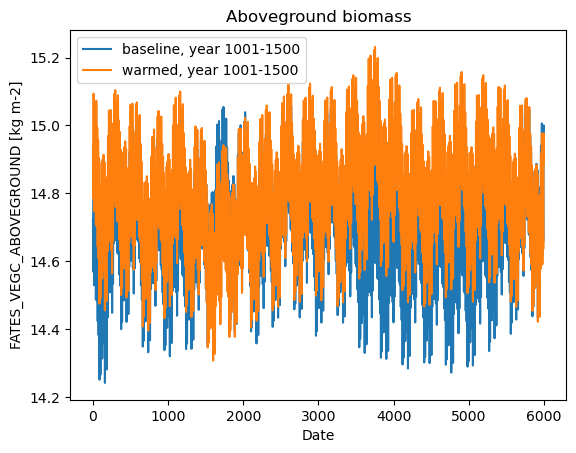

In [9]:
# make a plot with the same variable from all four data sets
fig, ax = plt.subplots()

# Plot the other variables var_1_1, var_1_3, var_2_1, var_2_3
#var_base.plot(ax=ax, label='baseline, year 1001-1500')
#var_warm.plot(ax=ax, label='warmed, year 1001-1500')

ax.plot(range(len(var_base.values)), var_base.values, label='baseline, year 1001-1500')
ax.plot(range(len(var_warm.values)), var_warm.values, label='warmed, year 1001-1500')

# Add legend to the plot
ax.legend()

# Axis labels
ax.set_xlabel("Date")
ax.set_ylabel(f"{var_name} [{output_nc_data_warm[var_name].units}]")

# Set title for the plot
ax.set_title('Aboveground biomass')

# save plot
plt.savefig(plot_save_path)

# Show the plot
plt.show()

Try to make a scatterplot with regression lines to show the difference between the two simulations:

In [15]:
# make a new data frame with the variables we need from both simulations
data = pd.DataFrame(columns=['aboveground_biomass_base', 'aboveground_biomass_warm'])

# Subset temperature, convert to deg. C
data['aboveground_biomass_base'] = output_nc_data_base['FATES_VEGC_ABOVEGROUND'].values.flatten()
data['aboveground_biomass_warm'] = output_nc_data_warm['FATES_VEGC_ABOVEGROUND'].values.flatten()


In [11]:
cm = 1/2.54
FIG_SIZE_CM = (9.5*cm, 7*cm)
FIG_SIZE_CM

(3.74015748031496, 2.755905511811023)

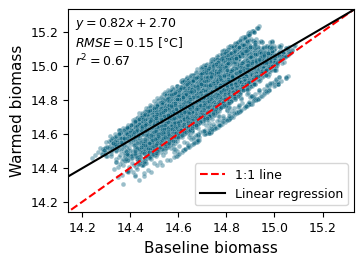

In [19]:
# Plot
fig, ax = plt.subplots(dpi=100, figsize=FIG_SIZE_CM)

ax.scatter(data['aboveground_biomass_base'],
           data['aboveground_biomass_warm'],
           s=12,
           edgecolors='white',
           color="#035e7b",
           linewidth=0.3,
           alpha=0.4
          )

# 1 to 1 line
ax.plot([x+1 for x in range(-40, 40)], 
        [x+1 for x in range(-40, 40)],
        color="red",
        linestyle="--",
        label="1:1 line"
       )

# Linear regression and statistics
import numpy as np
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data['aboveground_biomass_base'],
                                                                     data['aboveground_biomass_warm']
                                                                    )
plt.axline(xy1=(0, intercept),
           slope=slope, 
           label='Linear regression',
           color='black'
          )

# Calculate root mean square error
rmse = np.sqrt(np.mean(np.square(data['aboveground_biomass_base'] - data['aboveground_biomass_warm'])))

# Add lin. reg. formula and metrics as text to figure
from matplotlib.offsetbox import AnchoredText

text_box = AnchoredText(f'$y = {slope:.2f}x {intercept:+.2f}$\n$RMSE = {rmse:.2f}$ [°C]\n$r^2 = {r_value**2:.2f}$',
                        frameon=False, 
                        loc=2, 
                        pad=0,
                        prop=dict(fontsize=9)
                       )
# Text box layout
plt.setp(text_box.patch, 
         facecolor='none', 
         alpha=0.5
        )
ax.add_artist(text_box)

# General plot layout
ax.set_xlabel("Baseline biomass", fontsize=11)
ax.set_ylabel("Warmed biomass", fontsize=11)
offset = 0.1 
ax.set_xlim([min([min(data['aboveground_biomass_base']), min(data['aboveground_biomass_warm'])]) - offset, 
             max([max(data['aboveground_biomass_base']), max(data['aboveground_biomass_warm'])]) + offset]
           )
ax.set_ylim([min([min(data['aboveground_biomass_base']), min(data['aboveground_biomass_warm'])]) - offset, 
             max([max(data['aboveground_biomass_base']), max(data['aboveground_biomass_warm'])]) + offset]
           )
ax.tick_params(axis='both', which='major', labelsize=9)
ax.legend(fontsize=9)

# Save figure
fig.tight_layout()
fig.savefig(fname=f"{plot_save_path}/aboveground_biomass_base_vs_warmed.png", format='png')

Plot Gross Primary Production as well:

In [34]:
var_name = "FATES_GPP"

var_base = output_nc_data_base[var_name]
var_warm = output_nc_data_warm[var_name]

# subset only the last year of data

subset_time_start = '1500-05-01'  # Format: YYYY-MM-DD
subset_time_end = '1500-09-30'  # Format: YYYY-MM-DD

var_base_subset = var_base.sel(
    time=slice(subset_time_start, subset_time_end)
)
var_warm_subset = var_warm.sel(
    time=slice(subset_time_start, subset_time_end)
)
var_base_subset


<xarray.DataArray 'FATES_GPP' (time: 5, lndgrid: 1)>
dask.array<getitem, shape=(5, 1), dtype=float32, chunksize=(5, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1500-05-01 00:00:00 ... 1500-09-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      gross primary production in kg carbon per m2 per second
    units:          kg m-2 s-1
    cell_methods:   time: mean
    landunit_mask:  unknown

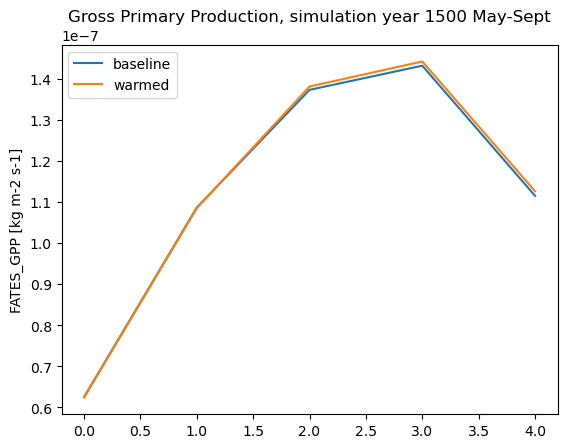

In [40]:
# make a plot with the same variable from all data sets
fig, ax = plt.subplots()

# Plot the other variables var_1_1, var_1_3, var_2_1, var_2_3
#var_base.plot(ax=ax, label='baseline, year 1001-1500')
#var_warm.plot(ax=ax, label='warmed, year 1001-1500')

ax.plot(range(len(var_base_subset.values)), var_base_subset.values, label='baseline')
ax.plot(range(len(var_warm_subset.values)), var_warm_subset.values, label='warmed')

# Add legend to the plot
ax.legend()

# Axis labels
ax.set_xlabel("")
ax.set_ylabel(f"{var_name} [{output_nc_data_warm[var_name].units}]")

# Set title for the plot
ax.set_title('Gross Primary Production, simulation year 1500 May-Sept')

# save plot
plt.savefig(plot_save_path)

# Show the plot
plt.show()

---
# Plotting variables with more dimensions
We will now create plots for a variable with more dimensions, namely `FATES_VEGC_PF`, which stores the amount of total biomass in kg of carbon per land area for each included PFT. Only comparing the last thousand years of both simulations here.

In [26]:
# Variable name for biomass per PFT in dataset
var_name = "FATES_VEGC_PF"

Start by subsetting the variable from the two data sets

In [28]:
pft_biomass_1 = output_nc_data_1_3[var_name]
pft_biomass_2 = output_nc_data_2_3[var_name]

The following cell reads and defines some FATES PFT properties as Python `dict`(ionary) objects that we will use for plotting.

In [29]:
"""
Load and create dictionaries defining PFT and plot properties.
NB: this is version and model setting dependent!
The 'fates_pft_dict' keys are the PFT indices used in the FATES output.
"""

with open(Path("./dicts/default_fates_pfts.json"), 'r', encoding='utf-8') as fates_pft_json:
    fates_pft_dict = json.load(fates_pft_json)

pft_group_plot_dict = {
    "tree": {
        "linestyle": "-"
    },
    "shrub": {
        "linestyle": "--"
    },
    "grass": {
        "linestyle": ":"
    }
}

Look at the biomass per PFT variable before making the next plot.

In [30]:
# Display variable details
pft_biomass_1

<xarray.DataArray 'FATES_VEGC_PF' (time: 12000, fates_levpft: 12, lndgrid: 1)>
dask.array<open_dataset-66342b83a406339a43aa9a9dbffd0cefFATES_VEGC_PF, shape=(12000, 12, 1), dtype=float32, chunksize=(12000, 12, 1), chunktype=numpy.ndarray>
Coordinates:
  * fates_levpft  (fates_levpft) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * time          (time) object 3901-02-01 00:00:00 ... 4901-01-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      total PFT-level biomass in kg of carbon per land area
    units:          kg m-2
    cell_methods:   time: mean
    landunit_mask:  unknown

Now let's use Matplotlib again to create a multi-line plot to depict the PFT biomass dynamics.

In [53]:
len(np.unique(pft_biomass_1.fates_levpft))

12

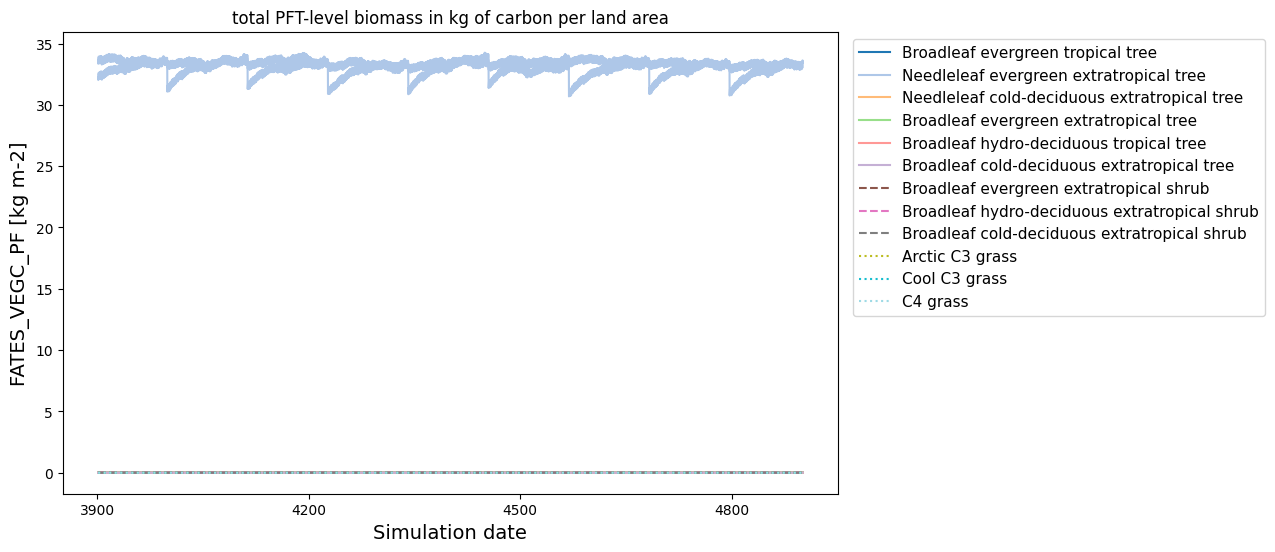

In [68]:
# Instantiate plot
fig, ax = plt.subplots(figsize=(10,6))

# Create a multi-line plot by looping through PFT properties
plot_handle_list = []

# Determine whether default or customized PFTs were used based on boolean variable
pft_dict = fates_pft_dict

# Define a colormap with colors for each unique PFT index
pft_index_colormap = plt.cm.get_cmap('tab20', len(np.unique(pft_biomass_1.fates_levpft)))

# Plot biomass for pft_biomass_1
for cur_pft_idx in np.unique(pft_biomass_1.fates_levpft):
    
    cur_pft_dict = pft_dict[str(int(cur_pft_idx))]
    
    # Get the color from the colormap based on the PFT index
    cur_color = pft_index_colormap(pft_biomass_1.fates_levpft.values.tolist().index(cur_pft_idx))
    
    # Plot biomass for current PFT index
    cur_plot_handles, = ax.plot(output_nc_data_1_3['time'],
                                pft_biomass_1.sel(fates_levpft=cur_pft_idx),
                                label=cur_pft_dict["long_name"],
                                color=cur_color,
                                linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
                                linewidth=1.5
                               )
    
    plot_handle_list.append(cur_plot_handles)

# Plot biomass for pft_biomass_2 using the same color as pft_biomass_1
for cur_pft_idx in np.unique(pft_biomass_2.fates_levpft):
    
    cur_pft_dict = pft_dict[str(int(cur_pft_idx))]
    
    # Get the color from the colormap based on the PFT index
    cur_color = pft_index_colormap(pft_biomass_2.fates_levpft.values.tolist().index(cur_pft_idx))
    
    # Plot biomass for current PFT index with the same color as pft_biomass_1
    ax.plot(output_nc_data_2_3['time'],
            pft_biomass_2.sel(fates_levpft=cur_pft_idx),
            label=cur_pft_dict["long_name"],
            color=cur_color,
            linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
            linewidth=1.5
           )

# Set overall plot layout
ax.set_title(f"{pft_biomass_1.long_name}")
ax.set_xlabel("Simulation date", fontsize=14)
ax.set_ylabel(f"{var_name} [{pft_biomass_1.units}]", fontsize=14)

ax.legend(
    handles=plot_handle_list,
    bbox_to_anchor=(1.01, 1),  # Places the legend outside to the plotting area
    loc='upper left',
    fontsize=11
)

# Show the plot
plt.show()


Note that this plot shows the **total PFT-level biomass**, ergo the sum of the above- and belowground biomasses of all respective PFT cohorts across all simulated patches, scaled to kg/m².

---
# `runtype = startup` - the simulation spin-up period

After we have learned how to read the data and how to create output plots while taking the differences in variable dimensions into account, we now want to focus on explaining what we see. One notorious challenge when using earth system models is the computationally expensive **spin-up phase**. When choosing `runtype=startup` in the model settings, which is the NorESM-LSP default, we start the model from a so-called "bare ground" state: the simulation commences from bare soil without any vegetation and empty carbon pools (soil, litter, etc.). In the beginning, fast-growing pioneer PFTs like grasses or fast-growing trees may thrive, before they are outcompeted by other plants or die if the climate is unsuitable. Consequently, model results that did not undergo a sufficiently long spin-up period should usually be considered invalid.

The spin-up period computational load can be maneageable for single-site simulations, but it gets more difficult the larger the simulated area is and the more model components you include. In CLM-FATES, the starting conditions are chiefly controlled by the `runtype` parameter - depending on its value, additional files and parameter changes may be required. For example, it is also possible to use a previous spin-up simulation as a starting point for other modelling experiments, which is currently not implemented in the NorESM-LSP's GUI.

Let's create plots to investigate some important state variables over our chosen simulation period.

_The following plots are inspired by the CTSM analysis tool mentioned [here](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/users_guide/running-special-cases/Spinning-up-the-biogeochemistry-BGC-spinup.html)._

In [18]:
# Use this cell to explore the variables defined below, if you want. E.g.:
# output_nc_data["TWS"]

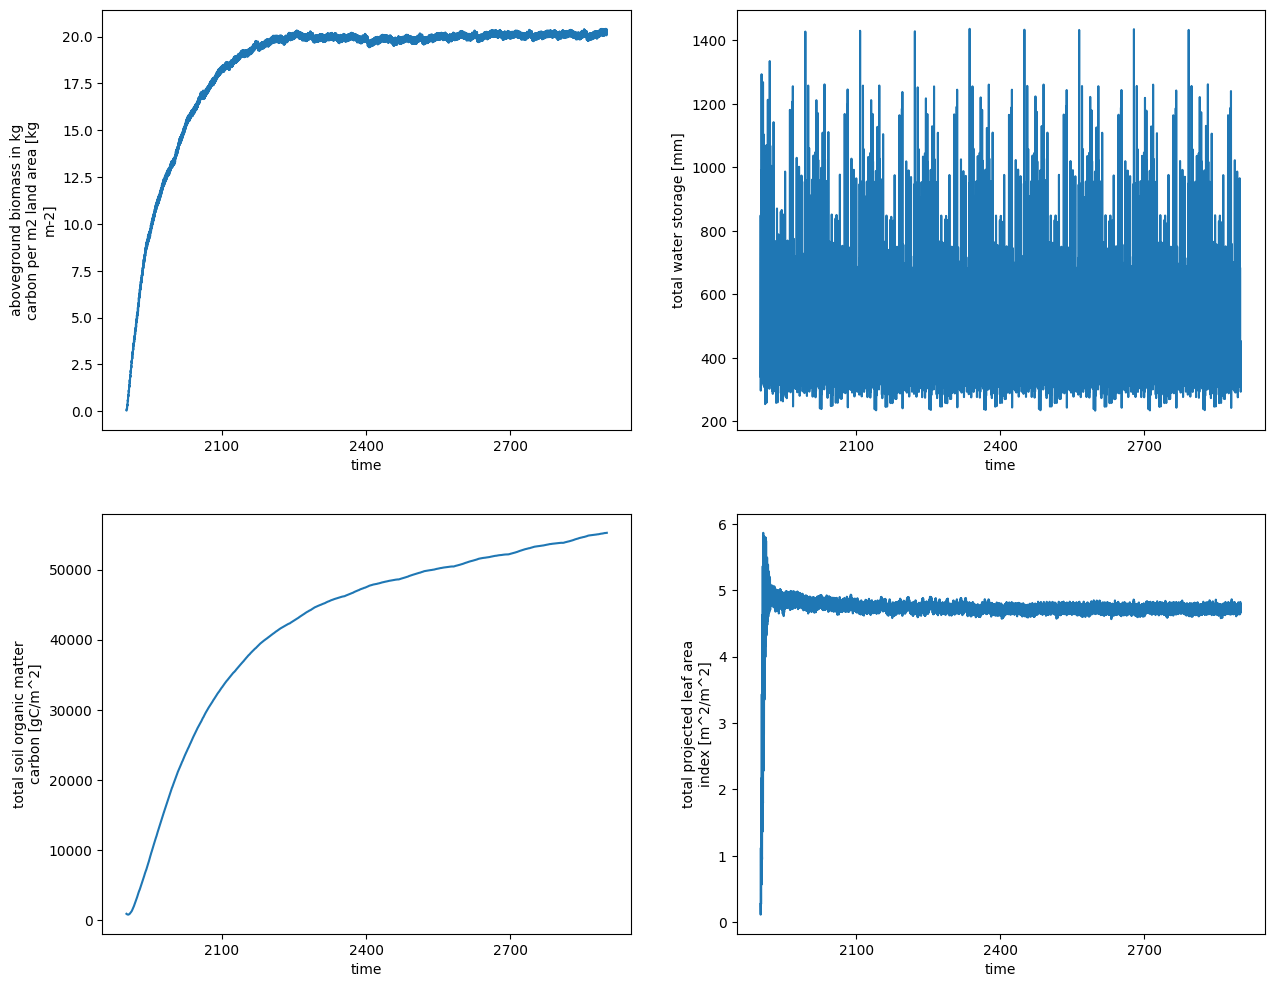

In [19]:
import math

# Variables to plot from 'output_nc_data', feel free to add more names to the list
var_names = ["FATES_VEGC_ABOVEGROUND", "TWS", "TOTSOMC", "TLAI"]

# Instantiate figure with subplot grid adapted to number of variables provided
fig, axes = plt.subplots(
    nrows=math.ceil(len(var_names)/2),
    ncols=2,
    figsize=(15, math.ceil(len(var_names)/2)*6)
)

# Delete empty axis object if number of variable names in list is odd
if len(axes.flatten()) != len(var_names):
    if len(axes.flatten()) == 2:
        fig.delaxes(axes[-1])
    else:
        fig.delaxes(axes[-1, -1])

# Plot all variables
for ax, var in zip(axes.flatten(), var_names):
    output_nc_data[var].plot(ax=ax)

If you used `runtype=startup` for your simulation, you should see that the values in the plots above start at a somewhat arbitrary value, fluctuate with the seasons, and commonly start increasing over several years. For sufficiently long periods they should stabilize over time: the vegetation and carbon pools reach an equilibrium state. The variables still fluctuate at equilibrium, driven by model processes such as disturbances and plant mortality, and by climatic variability in the forcing data, but the magnitudes and "overall patterns" do not change drastically anymore. Some state variables such as the soil carbon pool can take particularly long until they reach equilibrium due to the slow nature of the involved processes (decomposition, litter buildup, etc.). Reaching a steady state may take a long time, from hundreds to thousands of simulation years, especially in cold or dry climates where vegetation growth is slow.

---
# Carbon fluxes

A classic application for DGVMs is to investigate climate-vegetation interactions with respect to plants' crucial role in the carbon cycle. Accordingly, there are many ways to analyze how carbon "moves" between the different components of the models, for instance between the land surface and atmosphere. Let's explore some total annual C fluxes in the single-site simulation over time, summed across PFTs and patches.

In [20]:
# Display data again to investigate variables related to C fluxes
output_nc_data

<xarray.Dataset>
Dimensions:                           (levgrnd: 25, levsoi: 20, levlak: 10,
                                       levdcmp: 25, fates_levscls: 13,
                                       fates_levscag: 91, fates_levscpf: 156,
                                       fates_levcacls: 2, fates_levcapf: 24,
                                       fates_levage: 7, fates_levheight: 6,
                                       fates_levpft: 12, fates_levfuel: 6,
                                       ...
                                       fates_levagepft: 84,
                                       fates_levagefuel: 42, fates_levcdsc: 26,
                                       fates_levcdpf: 312, fates_levcdam: 2,
                                       time: 12000, hist_interval: 2,
                                       lndgrid: 1, fates_levelem: 1,
                                       fates_levelcwd: 4, glc_nec: 10, ltype: 9)
Coordinates: (12/15)
  * levgrnd                           (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                            (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                            (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                           (levdcmp) float32 0.01 0.04 ... 28.87 42.0
  * fates_levscls                     (fates_levscls) float32 0.0 5.0 ... 100.0
  * fates_levcacls                    (fates_levcacls) float32 0.0 5.0
    ...                                ...
  * fates_levfuel                     (fates_levfuel) int32 1 2 3 4 5 6
  * fates_levcwdsc                    (fates_levcwdsc) int32 1 2 3 4
  * fates_levcan                      (fates_levcan) int32 1 2
  * fates_levleaf                     (fates_levleaf) int32 1 2 3 4 ... 28 29 30
  * fates_levcdam                     (fates_levcdam) float32 0.0 80.0
  * time                              (time) object 1901-02-01 00:00:00 ... 2...
Dimensions without coordinates: fates_levscag, fates_levscpf, fates_levcapf,
                                fates_levcnlf, fates_levcnlfpf,
                                fates_levscagpf, fates_levagepft,
                                fates_levagefuel, fates_levcdsc, fates_levcdpf,
                                hist_interval, lndgrid, fates_levelem,
                                fates_levelcwd, glc_nec, ltype
Data variables: (12/505)
    fates_scmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_agmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_pftmap_levscpf              (fates_levscpf) int32 dask.array<chunksize=(156,), meta=np.ndarray>
    fates_scmap_levscpf               (fates_levscpf) int32 dask.array<chunksize=(156,), meta=np.ndarray>
    fates_pftmap_levcapf              (fates_levcapf) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    fates_camap_levcapf               (fates_levcapf) int32 dask.array<chunksize=(24,), meta=np.ndarray>
    ...                                ...
    WTGQ                              (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    W_SCALAR                          (time, levsoi, lndgrid) float32 dask.array<chunksize=(12000, 20, 1), meta=np.ndarray>
    ZBOT                              (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT                               (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT_CH4_UNSAT                     (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
    ZWT_PERCH                         (time, lndgrid) float32 dask.array<chunksize=(12000, 1), meta=np.ndarray>
Attributes: (12/36)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Mon Mar 2

Choose which variables to plot:

In [21]:
# Names of the variables that represent important C fluxes
# It is possible to add new variable names to the list (plots will be added automatically)
c_flux_var_names = ["FATES_VEGC_ABOVEGROUND", "FATES_NPP", "FATES_NEP", "FATES_GPP", "CH4PROD", "FATES_AUTORESP"]
c_flux_vars = [output_nc_data[s] for s in c_flux_var_names]

Create plots:

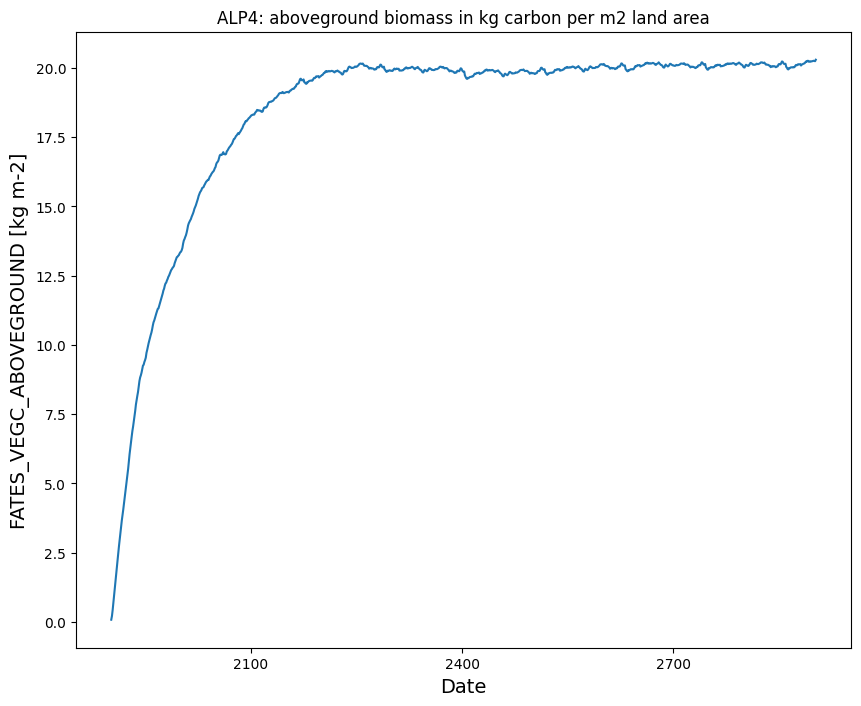

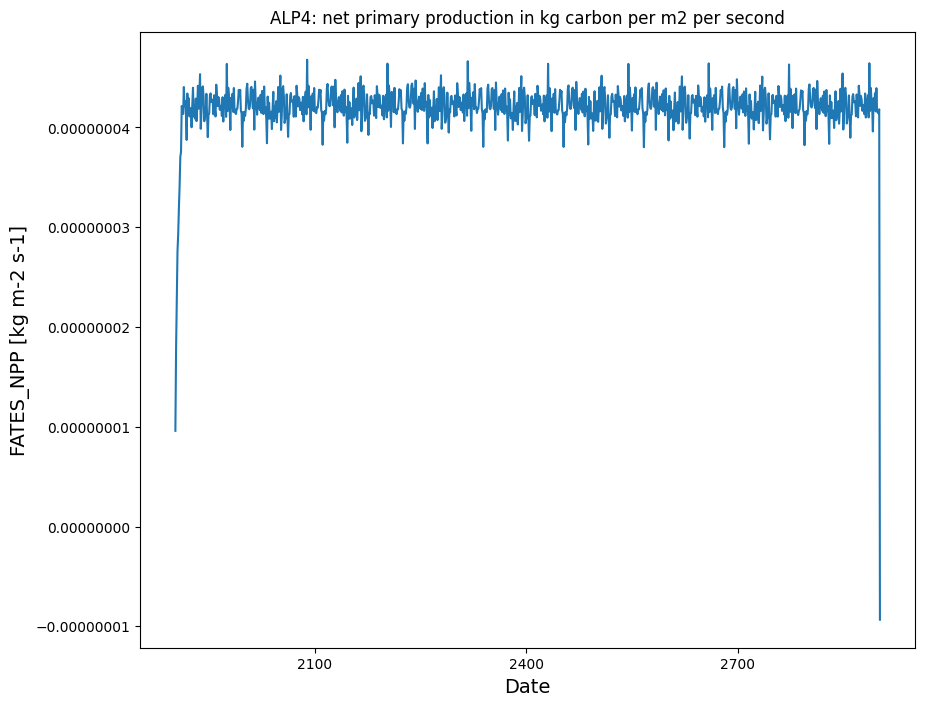

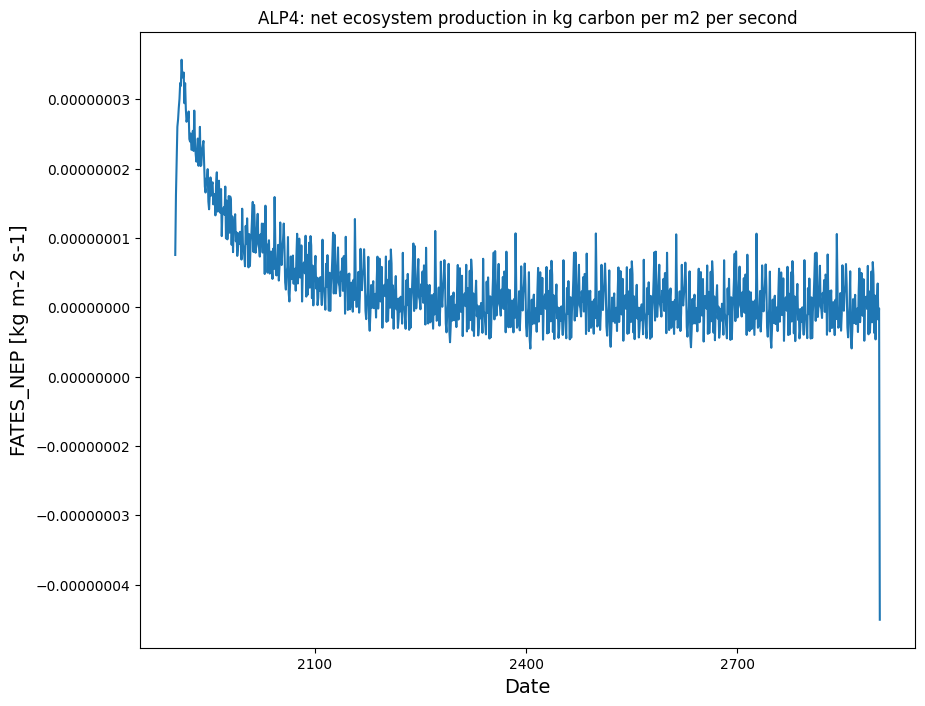

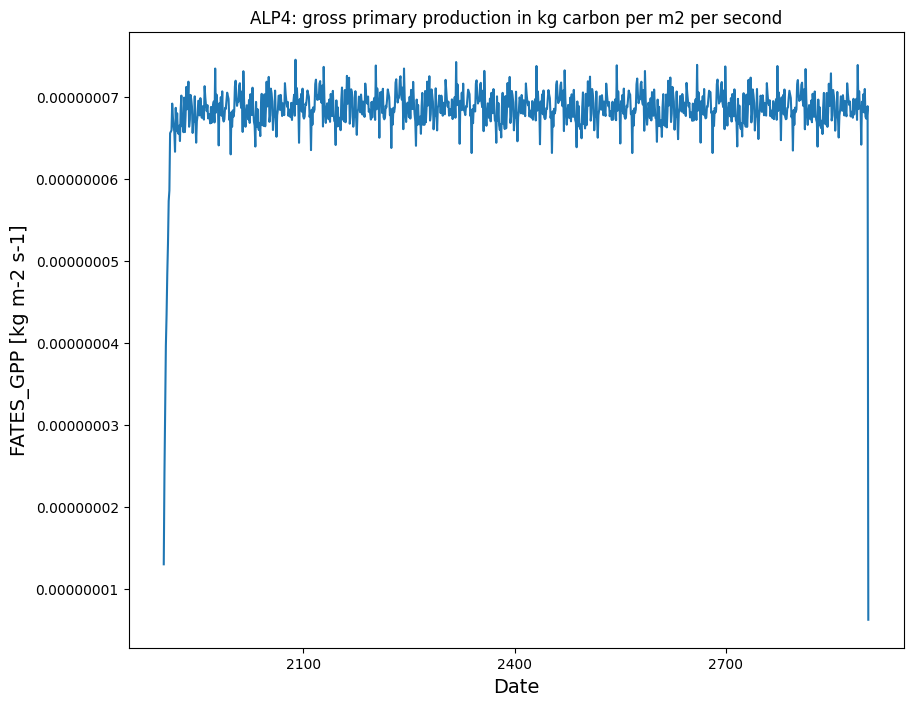

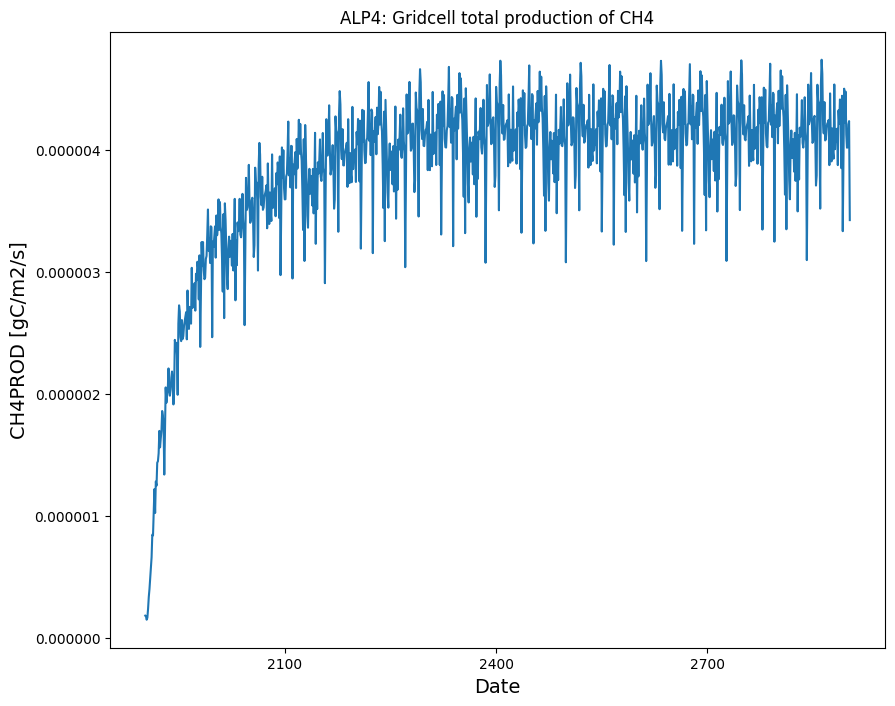

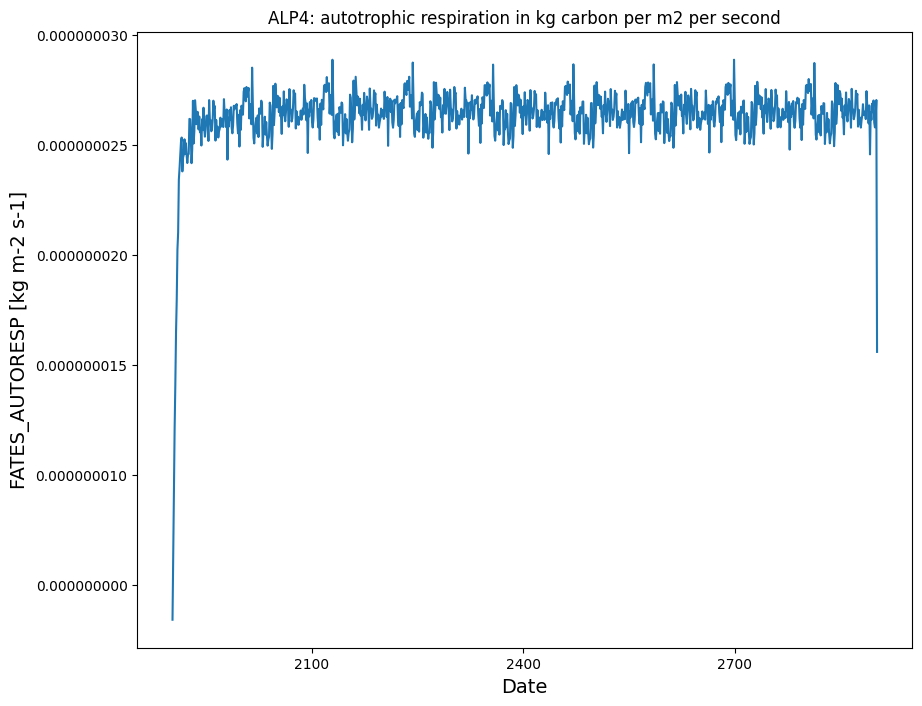

In [22]:
for c_var in c_flux_vars:
    fig, ax = plt.subplots(figsize=(10,8))
    
    c_var_annual = c_var.resample(time='1Y').mean()
    
    #cur_plot_handle, = \
    ax.plot(c_var_annual['time'], c_var_annual, label=c_var.long_name.capitalize())

    ax.set_title(f"{site_code}: {c_var.long_name}")
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel(f"{c_var.name} [{c_var.units}]", fontsize=14)
    
    # Use plain notation, i.e., avoid scientific "1e-3" notation
    ax.ticklabel_format(style='plain', axis='y')